In [322]:
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path

from tqdm import tqdm

import os
import glob
import json
import random


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [323]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [324]:
on_pc = os.path.isdir('data')
if on_pc: 
    data_directory = "data"
else:
    data_directory = "/kaggle/input/hubmap-hacking-the-human-vasculature"

# Goals of the Competition
Goal of the Competition
The goal of this competition is to segment instances of microvascular structures, including capillaries, arterioles, and venules. You'll create a model trained on 2D PAS-stained histology images from healthy human kidney tissue slides.

Your help in automating the segmentation of microvasculature structures will improve researchers' understanding of how the blood vessels are arranged in human tissues

# Dataset description
Your goal in this competition is to locate microvasculature structures (blood vessels) within human kidney histology slides.

The competition data comprises tiles extracted from five Whole Slide Images (WSI) split into two datasets. Tiles from Dataset 1 have annotations that have been expert reviewed. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.

- All of the test set tiles are from Dataset 1.
- Two of the WSIs make up the training set, two WSIs make up the public test set, and one WSI makes up the private test set.
- The training data includes Dataset 2 tiles from the public test WSI, but not from the private test WSI.

We also include, as Dataset 3, tiles extracted from an additional nine WSIs. These tiles have not been annotated. You may wish to apply semi- or self-supervised learning techniques on this data to support your predictions.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data drawn from the public test set to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 650 tiles in the full test set.

You may find resources from the previous HuBMAP competitions useful as well:

- HuBMAP: Hacking the Kidney (https://www.kaggle.com/competitions/hubmap-kidney-segmentation/)
- HuBMAP + HPA: Hacking the Human Body (https://www.kaggle.com/competitions/hubmap-organ-segmentation/)

## Files and Field Descriptions
**{train|test}/ Folders** - containing TIFF images of the tiles. Each tile is 512x512 in size.

In [325]:
def number_tif_files(directory):
    file_pattern = f'{directory}*.tif'
    tif_files = glob.glob(file_pattern)
    print(f'Number .tif files in {directory}: {len(tif_files)}')

number_tif_files(f'{data_directory}/train/')
number_tif_files(f'{data_directory}/test/')

Number .tif files in data/train/: 7033
Number .tif files in data/test/: 1


**sample_submission.csv** - A sample submission file in the correct format. See the Evaluation page (https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/overview/evaluation) for more details:
- bitová maska stejné velikosti jako obrázek (512 x 512), která je převedena na **prediction_string**
- **prediction_string** has the format 0 {confidence} {EncodedMask}
- Segmentation is calculated using IoU (Intersection over Union) with a threshold of 0.6

In [326]:
pd.read_csv(f'{data_directory}/sample_submission.csv')

,id,height,width,prediction_string
0,72e40acccadf,512,512,0 1.0 eNoLTDAwyrM3yI/PMwcAE94DZA==


**polygons.jsonl** - Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image with:
- id Identifies the corresponding image in train/
- annotations A list of mask annotations with:
- type Identifies the type of structure annotated:
    - **blood_vessel** The target structure. Your goal in this competition is to predict these kinds of masks on the test set.
    - **glomerulus** A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should *ensure none of your test set predictions occur within glomerulus structures as they will be counted as false positives*. Annotations are provided for test set tiles in the hidden version of the dataset.
    - **unsure** A structure the expert annotators cannot confidently distinguish as a blood vessel.
- coordinates A list of polygon coordinates defining the segmentation mask.

In [327]:
jsonObj = pd.read_json(path_or_buf=f"{data_directory}/polygons.jsonl", lines=True, encoding="UTF-8")
jsonObj

,id,annotations
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."
...,...,...
1628,ff434af74304,"[{'type': 'blood_vessel', 'coordinates': [[[29..."
1629,ff4897b3eda6,"[{'type': 'blood_vessel', 'coordinates': [[[29..."
1630,ff66dec71c4c,"[{'type': 'blood_vessel', 'coordinates': [[[11..."
1631,ff99cdef0f2a,"[{'type': 'blood_vessel', 'coordinates': [[[24..."


In [328]:
#with open(f"{data_directory}/polygons.jsonl", "rb") as f:
#    print(json.load(f"{data_directory}/polygons.jsonl"))

with open(f"{data_directory}/polygons.jsonl",'r') as json_file:
    json_list = list(json_file)

result = {}
result_ids = []
for json_str in json_list:
    obj = json.loads(json_str)
    result[obj["id"]] = obj["annotations"]
    result_ids.append(obj["id"])

print(result["0006ff2aa7cd"])


[{'type': 'glomerulus', 'coordinates': [[[167, 249], [166, 249], [165, 249], [164, 249], [163, 249], [162, 249], [161, 249], [160, 249], [159, 249], [158, 249], [157, 249], [156, 249], [155, 249], [154, 249], [153, 249], [152, 249], [151, 249], [150, 249], [149, 249], [148, 249], [147, 249], [146, 249], [145, 249], [144, 249], [143, 249], [142, 249], [141, 249], [140, 249], [139, 249], [138, 249], [137, 249], [136, 249], [135, 249], [134, 249], [133, 249], [132, 249], [131, 249], [130, 249], [129, 249], [128, 249], [127, 249], [126, 249], [125, 249], [124, 249], [123, 249], [122, 249], [122, 248], [121, 248], [120, 248], [119, 248], [118, 248], [117, 248], [117, 247], [116, 247], [115, 247], [115, 246], [114, 246], [113, 246], [112, 246], [111, 246], [110, 246], [110, 245], [109, 245], [108, 245], [107, 245], [106, 245], [106, 244], [105, 244], [105, 243], [104, 243], [103, 243], [103, 242], [102, 242], [101, 242], [100, 242], [99, 242], [99, 241], [98, 241], [98, 240], [97, 240], [97,

In [329]:
def to_bitmap(coordinates):
    coordinates = np.squeeze(coordinates)
    res = np.zeros([512, 512])
    for [x, y] in coordinates:
        res[y, x] = 1
    return res

a = to_bitmap(result["0006ff2aa7cd"][0]["coordinates"])
a

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

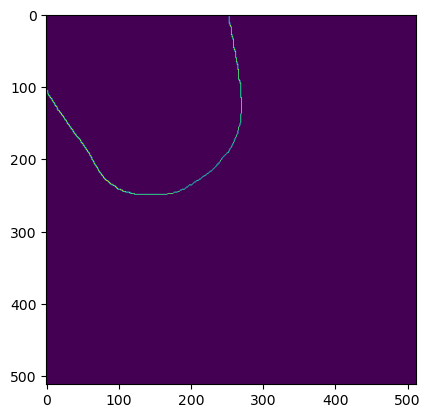

In [330]:
plt.imshow(a)
plt.show()

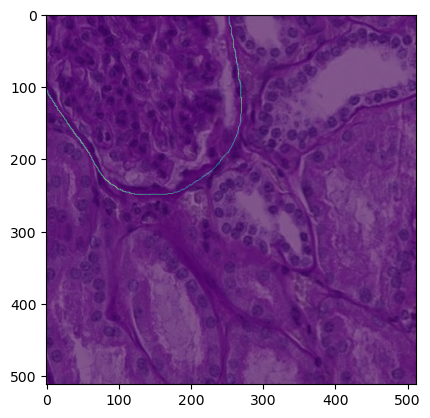

In [331]:
I = plt.imread(f"{data_directory}/train/0006ff2aa7cd.tif")
plt.imshow(I)
plt.imshow(a, alpha=0.6)
plt.show()

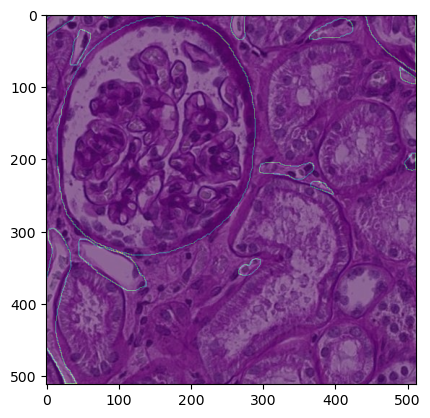

In [332]:
l = []
for i in range(len(result["00da8fdf2391"])):
    arr = result["00da8fdf2391"][i]["coordinates"]
    bitmap = to_bitmap(arr)
    # print(bitmap.shape)
    l.append(bitmap)

l = np.array(l)
#print(l.shape)
arr = np.sum(l, axis=0)
#print(arr.shape)


I = plt.imread(f"{data_directory}/train/00da8fdf2391.tif")
plt.imshow(I)


plt.imshow(arr, alpha=0.5)


plt.show() 

**tile_meta.csv** - Metadata for each image. The hidden version of this file also contains metadata for the test set tiles.
* source_wsi Identifies the WSI this tile was extracted from.
* {i|j} The location of the upper-left corner within the WSI where the tile was extracted.
* dataset The dataset this tile belongs to, as described above.

In [333]:
tile_meta = pd.read_csv(f"{data_directory}/tile_meta.csv")
tile_meta

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008
...,...,...,...,...,...
7028,ffd37b5c6598,13,3,13824,21504
7029,ffd3d193c71e,3,2,7680,16896
7030,ffd77e2517af,13,3,15872,28160
7031,ffe3cbb81f72,10,3,15456,23000


**wsi_meta.csv** - Metadata for the Whole Slide Images the tiles were extracted from.
* source_wsi Identifies the WSI.
* age, sex, race, height, weight, and bmi demographic information about the tissue donor.

In [334]:
pd.read_csv(f"{data_directory}/wsi_meta.csv")

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


# Data analysis

### Visualize the given image and its 8 surrounding images

printed image is 9ab13c781cbd
image with given position 11275, 11681 and wsi 14 should not exists
image with given position 11275, 12193 and wsi 14 should not exists
image with given position 12299, 11681 and wsi 14 should not exists
image with given position 12299, 12705 and wsi 14 should not exists


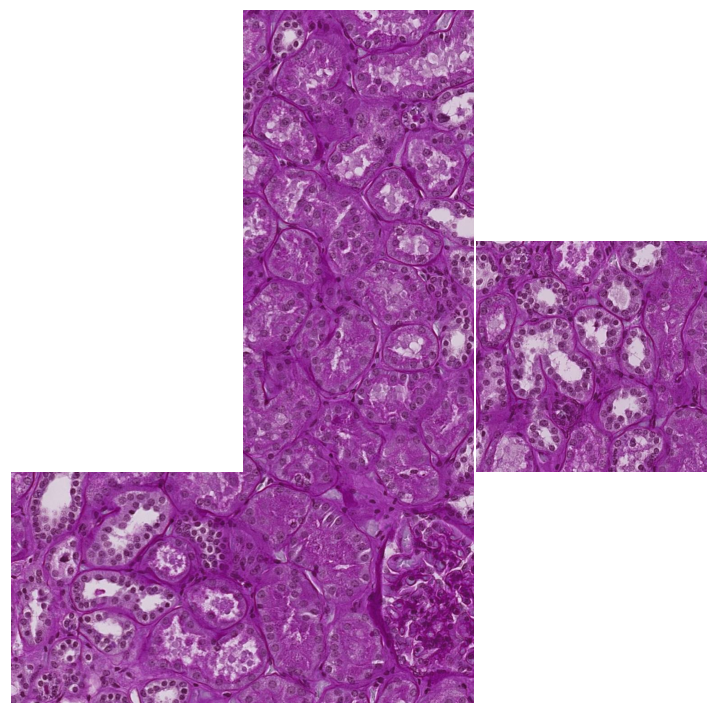

In [335]:
def visualize_surrounding_images(img_id: str) -> None:
    # Get the central image
    img = tile_meta.loc[tile_meta["id"] == img_id]
    img_i, img_j = img["i"].values[0], img["j"].values[0]
    img_wsi = img["source_wsi"].values[0]

    # position of the first image
    x, y = img_i - 512, img_j - 512

    # image plot frame
    grid_size = 3
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(9, 9))

    # iterate over the grid
    for i in range(grid_size):
        for j in range(grid_size):
            axs[j, i].axis('off')
            x_, y_ = x + i * 512, y + j * 512
            try:
                current_img = tile_meta.loc[(tile_meta["i"] == x_) & 
                                            (tile_meta["j"] == y_) & 
                                            (tile_meta["source_wsi"] == img_wsi)]["id"].values[0]
            except IndexError:
                print(f"image with given position {x_}, {y_} and wsi {img_wsi} should not exists")
                continue
            
            # display the image in the corresponding subplot
            img_file = f"{data_directory}/train/{current_img}.tif"
            try:
                image = plt.imread(img_file)
                axs[j, i].imshow(image)
            except FileNotFoundError:
                continue

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# load images to a list
# https://stackoverflow.com/questions/7336096/python-glob-without-the-whole-path-only-the-filename
img_file = [os.path.basename(x) for x in glob.glob(f'{data_directory}/train/*.tif')]
img_filename = str(random.choice(img_file))[:-4]

print(f"printed image is {img_filename}")
visualize_surrounding_images(img_filename)

# some images do not have all surrounding images

### Grayscale conversion

In [336]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def convert_all_gray(parent_path='./', gray_dir_name='train_gray'):
    gray_path = os.path.join(parent_path, gray_dir_name)
    print(f"Converted pictures will be saved to '{gray_path}'")
    Path(gray_path).mkdir(exist_ok=True)

    tif_files = glob.glob(os.path.join(f'{data_directory}/train', '*.tif'))
    for file_path in tqdm(tif_files):
        gray_file_path = os.path.join(gray_path, os.path.basename(file_path))

        # if exists don't convert again
        if os.path.exists(gray_file_path):
            continue

        img = np.array(Image.open(file_path))
        img_gray = rgb2gray(img)

        Image.fromarray(img_gray).save(gray_file_path)

# convert_all_gray()

#gray_image_filename = glob.glob(f'{data_directory}/train_gray/*.tif')[0]
#print(f'Visualizing {gray_image_filename}')
#
#img = mpimg.imread(gray_image_filename)
#img_show = plt.imshow(img, cmap=plt.get_cmap('gray'))

### Testing if there is any image that has no annotation

In [337]:
tif_files = glob.glob(os.path.join(f'{data_directory}/train', '*.tif'))
without_annotation = []
for file_path in tif_files:
    file_name = Path(file_path).name.split('.')[0]
    try:
        result[file_name]
    except:
        without_annotation.append(file_name)

print(f"{len(without_annotation)} images does not have annotations")

dic = {}
for tif_id in without_annotation:
    source_wsi = tile_meta.loc[tile_meta["id"] == without_annotation[0]]['source_wsi'].item()
    dic[source_wsi] = dic.get(source_wsi, 0) + 1

print(dic)

5400 images does not have annotations
{6: 5400}


In [338]:
import cv2

def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

#image  deskew function
def  deskew_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image  gray  function
def  gray_image(image):
    mask = create_mask_for_image(image)
    output = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
    return output/255

#image  thresh  function
def  thresh_image(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    output = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV) #+cv.THRESH_OTSU)
    return output


#image  rnoise  function
def  rnoise_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image  dilate  function
def  dilate_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image  erode  function
def  erode_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image  opening  function
def  opening_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image canny function
def  canny_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image segmentation function
def segment_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp




l = []
for i in range(len(result["00da8fdf2391"])):
    arr = result["00da8fdf2391"][i]["coordinates"]
    bitmap = to_bitmap(arr)
    # print(bitmap.shape)
    l.append(bitmap)

l = np.array(l)
#print(l.shape)
arr = np.sum(l, axis=0)
#print(arr.shape)

img = cv2.imread('data/train/00da8fdf2391.tif')


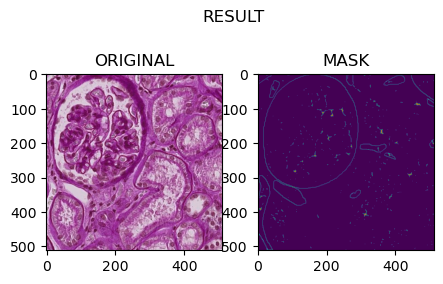

In [339]:

#mask
image_mask = create_mask_for_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
#plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MASK', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[1].imshow(arr, alpha=0.5)

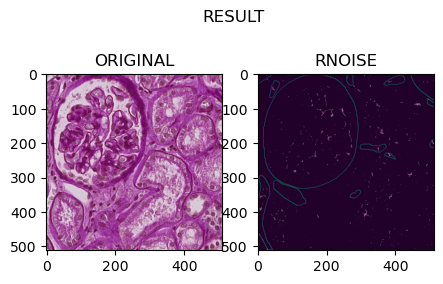

In [340]:
#rnoise
image_rnoise = rnoise_image(img)

fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('RNOISE', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_rnoise);
ax[1].imshow(arr, alpha=0.5)

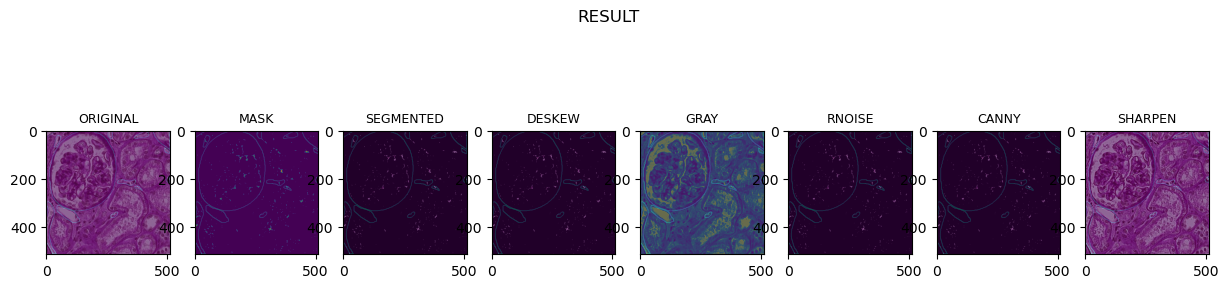

In [341]:
image_mask = create_mask_for_image(img)

#segmentation
image_segmented = segment_image(img)


#deskew
image_deskew = deskew_image(img)

#gray
image_gray = gray_image(img)


#rnoise
image_rnoise = rnoise_image(img)

#canny
image_canny = canny_image(img)

#sharpen the image
image_sharpen = sharpen_image(img)

fig, ax = plt.subplots(1, 8, figsize=(15, 6));
plt.suptitle('RESULT', x=0.5, y=0.8)

ax[0].set_title('ORIGINAL', fontsize=9)
ax[1].set_title('MASK', fontsize=9)
ax[2].set_title('SEGMENTED', fontsize=9)
ax[3].set_title('DESKEW', fontsize=9)
ax[4].set_title('GRAY', fontsize=9)
ax[5].set_title('RNOISE', fontsize=9)
ax[6].set_title('CANNY', fontsize=9)
ax[7].set_title('SHARPEN', fontsize=9)

ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_deskew);
ax[4].imshow(image_gray );
ax[5].imshow(image_rnoise);
ax[6].imshow(image_canny);
ax[7].imshow(image_sharpen);

ax[0].imshow(arr, alpha=0.5)
ax[1].imshow(arr, alpha=0.5)
ax[2].imshow(arr, alpha=0.5)
ax[3].imshow(arr, alpha=0.5)
ax[4].imshow(arr, alpha=0.5)
ax[5].imshow(arr, alpha=0.5)
ax[6].imshow(arr, alpha=0.5)
ax[7].imshow(arr, alpha=0.5)


# Nápady
*   4 třídy pro kazdy pixel (nic, unsure, g...., blood_vessel)
*   0-100,100-200,200-300 třídy. skoro regresní uloha
*   (100, 512,512)


### Models
*   UNET
*   RCNN

### Todo
### Vizualizace
*   id obrazku -> zobrazeni obrazku + okolnich
*   

## Dataset & Dataloader

In [342]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image

from enum import IntEnum

class StructureValue(IntEnum):

    BLOOD_VESSEL = 1
    GLOMERULUS = 2
    #BOTH = 3
    UNSURE = 4

    
    @staticmethod
    def get_value(type):
        if type == 'blood_vessel':
            return StructureValue.BLOOD_VESSEL
        elif type == 'glomerulus':
            return StructureValue.GLOMERULUS
        else:
            return StructureValue.UNSURE


class TifImageDataset(Dataset):
    def __init__(self, img_dir, annotation_file, add_rotated=True, count=-1):
        self.add_rated = add_rotated

        self.img_dir = img_dir
        self.tif_files = [f for f in os.listdir(img_dir)]
        self.tif_files = np.array(self.tif_files)

        # custom dataset size
        if count == -1:
            count = len(self.tif_files)
        self.tif_files = self.tif_files[:count]
        
        # Rotating images
        print(len(self.tif_files))
        if add_rotated:
            rotated = self.tif_files
            for rotation in ('90', '180', '270'):
                rotated = np.append(rotated, ([file + '.' + rotation for file in os.listdir(img_dir)]))
            self.tif_files = rotated

        # load polygons.jsonl file
        with open(f"{data_directory}/polygons.jsonl",'r') as json_file:
            json_list = list(json_file)
        
        # convert lines to dictionary
        result = {}
        for json_str in json_list:
            obj = json.loads(json_str)
            result[obj["id"]] = obj["annotations"]
        
        self.annotations = result
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.tif_files)

    """
    Converts array of coordinates to 512x512 bitmap (contains 1 if coordinate is present 0 otherwise)
        coordinates (2d array): x, y coordinates
    Returns:
        type: Description of the return value.
    """
    def to_bitmap(coordinates):
        coordinates = np.squeeze(coordinates)
        res = np.zeros([512, 512], dtype=np.float32)
        for (x, y) in coordinates:
            res[x, y] = 1
        return res
    
    def __getitem__(self, idx):
        image_name = self.tif_files[idx]

        # get part after '.tif'
        str_to_found = '.tif'
        index = image_name.index(str_to_found) + len(str_to_found)
        part_after = image_name[index: ]

        image_name = image_name[:index]
        #print(image_name)
        rotate_times = (int(part_after[1:]) / 90) % 4 if part_after else 0
        #if rotate_times:
        #    print('rotatiiiiiiiiiiiiiiiing', rotate_times)

        image = np.rot90(plt.imread(os.path.join(self.img_dir, image_name)).astype(np.float32), rotate_times)
        
        # looking for mask
        mask = np.zeros([512, 512], dtype=np.float32)
        image_uid = image_name.split('.')[0]
        if image_uid in self.annotations:
            for annotation in self.annotations[image_uid]:
                type_value = StructureValue.get_value(annotation['type'])
                if type_value == StructureValue.BLOOD_VESSEL:
                    mask = to_bitmap(annotation['coordinates'])
                        
            
            mask = np.rot90(mask, rotate_times)
            

        image = image/255
        image = image.reshape(3, 512,512)
        mask = mask.reshape(1, 512, 512)

        image = torch.from_numpy(image.copy()).float()
        mask = torch.from_numpy(mask.copy()).float()
        image.requires_grad = True
        mask.requires_grad = True

        return image, mask


#train_dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl')
#mask = train_dataset.__getitem__(1760)[1]


In [343]:
dat = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl')

for i in range(1000):
    #print(i)
    continue
    dat.__getitem__(i)

7033


## Neural network

In [344]:


class UNet(nn.Module):
    def __init__(self, num_classes=1, device="cpu"):
        super(UNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=num_classes, kernel_size=1, dtype=torch.float32)
        self.sigmoid = nn.Sigmoid()
        self.device=device

    def forward(self, x):
        # The output layer simply applies a 1x1 convolution to map the input channels to the number of classes
        x = self.conv(x)
        x = self.sigmoid(x)
        return x
    def predict(self, x):
        with torch.no_grad():
            y_pred = self.forward(x)
        return (y_pred > 0.5) * 1.0

with torch.no_grad():
    model = UNet(1)
    input = torch.randn(1, 3, 512, 512)
    output = model(input)
    print(input.shape, output.shape)

torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])


1
  batch 1 loss: 1.01032
  batch 21 loss: 1.00182
  batch 41 loss: 0.99235
  batch 61 loss: 0.98537
  batch 81 loss: 0.97724
  batch 101 loss: 0.96783
  batch 121 loss: 0.95798
  batch 141 loss: 0.95241
  batch 161 loss: 0.94597
  batch 181 loss: 0.93863
  batch 201 loss: 0.92721


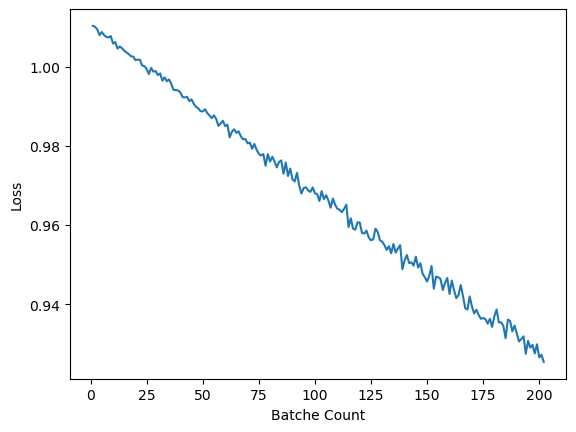

In [345]:
def train_one_epoch(model, loss_function, optimizer, training_loader, batch_stop = 999999, verbose_interval = 10, verbose = True, show_graph = False):
    running_cum_loss = 0
    losses = []
    example_count = 0
    for i, data in enumerate(training_loader):
        inputs, labels = data
        example_count += len(labels) # batch size

        optimizer.zero_grad()

        outputs = model(inputs)
        
        #print(inputs.shape, labels.shape, outputs.shape, )
        #print(str(outputs)[:200])
        #print(str(labels)[:200])
        loss = loss_function(outputs, labels)
        loss.backward()
        
        optimizer.step() # Adjust learning weights
        #print(loss)
        #return 0

        #  report
        losses.append(loss.item())
        running_cum_loss += loss.item() * inputs.shape[0]
        if verbose == True:
            if i % verbose_interval == 0:
                print(f"  batch {i+1} loss: {loss.item():.5f}")
            

       # idk why it doesnt end
        if i > batch_stop:
            break
    if show_graph:
        plt.plot(range(1,len(losses)+1),losses, '-')
        plt.ylabel("Loss")
        plt.xlabel("Batche Count")
        plt.show()
    # returns avg loss
    return running_cum_loss / example_count


torch.manual_seed(1)

simple_model = UNet()
loss_function = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(simple_model.parameters(), lr=0.001) 

training_dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', count=1)

training_loader = DataLoader(training_dataset, batch_size=5, shuffle=True) 

average_loss = train_one_epoch(simple_model, loss_function, optimizer, training_loader, batch_stop=100, verbose_interval=20, verbose=True, show_graph=True)

In [346]:
def calculate_accuracy(model, dataloader, break_after = -1):

    if break_after == -1:
        break_after == dataloader.__len__()
    with torch.no_grad():
        model.eval()  # Set the model in evaluation mode

        total_correct = 0
        total_samples = 0

        for i, (inputs, labels) in enumerate(dataloader):
            if i > break_after:
                break 
            # Move data to the same device as the model (CPU or GPU)
            inputs = inputs.reshape(1, 3, 512, 512).to(model.device)
            labels = labels.reshape(1, 1, 512, 512).to(model.device)

            # Make predictions on the batch
            predictions = model.predict(inputs)

            # Convert predictions and labels to numpy arrays for easier comparison
            predictions = predictions.cpu().numpy().flatten()
            labels = labels.cpu().numpy().flatten()

            # Count the correct predictions in the batch
            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)

        # Calculate the accuracy
        accuracy = total_correct / total_samples

        model.train()  # Set the model back to training mode

    return accuracy

calculate_accuracy(simple_model, dat, break_after=10)

0.9984325062144886

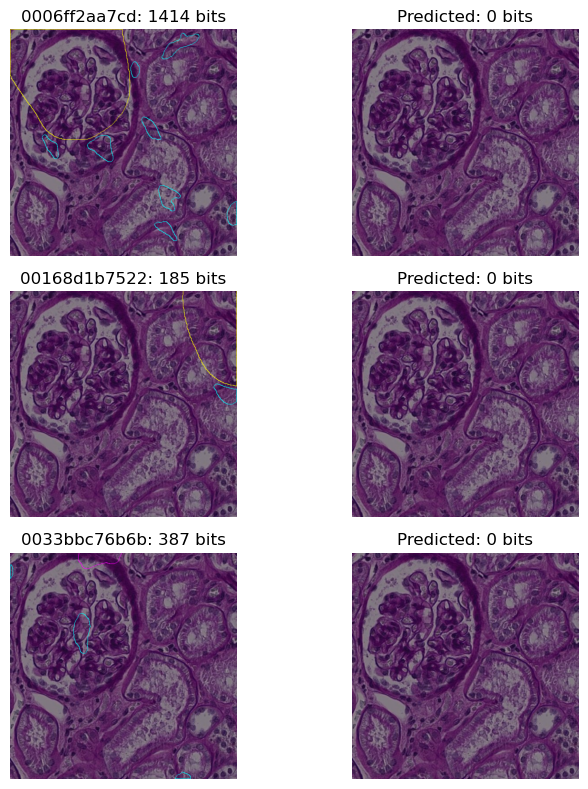

In [347]:
def overlay_image_with_bitmap(image, bitmap, color=(255, 0, 0)):
    # Create a mask from the binary bitmap (convert it to a 3-channel mask)
    mask = np.stack([bitmap, bitmap, bitmap], axis=-1)

    # Set the color for the areas where the mask is one
    mask *= np.array(color)

    # Blend the original image and the colored mask
    overlaid_image = image.copy()
    overlaid_image[bitmap == 1] = mask[bitmap == 1]

    return overlaid_image

def get_labeled_image(id, image_opacity=0.6):
    img = plt.imread(f"{data_directory}/train/{id}.tif")

    blood_vessels = np.zeros([512, 512])
    glomeruluses = np.zeros([512, 512])
    unsures = np.zeros([512, 512])
    for annotations in result[id]:
        if annotations["type"] == "blood_vessel":
            blood_vessels += to_bitmap(annotations["coordinates"])
        elif annotations["type"] == "glomerulus":
            glomeruluses += to_bitmap(annotations["coordinates"])
        elif annotations["type"] == "unsure":
            unsures += to_bitmap(annotations["coordinates"])
            
    img = np.array(I * image_opacity).astype(int) # decrease opacity of image

    img = overlay_image_with_bitmap(img, blood_vessels, (0, 255, 255))
    img = overlay_image_with_bitmap(img, glomeruluses, (255, 255, 0))
    img = overlay_image_with_bitmap(img, unsures, (255, 0, 255))
    return img, blood_vessels

def get_predicted_image(model, id, image_opacity=0.6):
    img = plt.imread(f"{data_directory}/train/{id}.tif")
    img = img.reshape(1,3,512,512)
    output = model.predict(torch.from_numpy(img.copy()).float())

    output = output.squeeze()

    mask = np.zeros(output.shape)
    for y in range(output.shape[0]):
        for x in range(output.shape[1]):
            mask[y, x] = output[y,x]

    img = np.array(I * image_opacity).astype(int) # decrease opacity of image

    img = img.reshape(512,512, 3)
    img = overlay_image_with_bitmap(img, mask, (0, 255, 255))

    return img, mask

def pred_vs_label(model, ids, image_opacity=0.6):
    if isinstance(ids, str) :
        ids = [ids]
        print("hi")

    fig, axes = plt.subplots(nrows=len(ids), ncols=2, figsize=(8, 8))
        
    for i in range(len(ids)):
        labeled, l_mask = get_labeled_image(ids[i], image_opacity)
        predicted, p_mask = get_predicted_image(model, ids[i], image_opacity)
        
        axes[i][0].set_title(f"{ids[i]}: {np.sum(l_mask):.0f} bits")
        axes[i][0].imshow(labeled)
        axes[i][1].set_title(f"Predicted: {np.sum(p_mask):.0f} bits")
        axes[i][1].imshow(predicted)

        axes[i][0].axis('off')
        axes[i][1].axis('off')

    fig.tight_layout()
    plt.show()

pred_vs_label(simple_model, result_ids[:3])

In [348]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNetComplex(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, device="cpu"):
        super(UNetComplex, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256 + 256, 128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(128 + 128, 64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(64 + 64, out_channels, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

        self.device = device

    def forward(self, x):
        # Downsample path
        x1 = self.down1(x)
        x2 = self.down2(nn.MaxPool2d(2)(x1))
        x3 = self.down3(nn.MaxPool2d(2)(x2))
        x4 = self.down4(nn.MaxPool2d(2)(x3))
        
        # Upsample path with skip connections
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up4(x)
        
        # Apply sigmoid activation
        x = self.sigmoid(x)
        
        return x
    def predict(self, x):
        with torch.no_grad():
            y_pred = self.forward(x)
        return (y_pred > 0.5) * 1.0

# Test the model with example input
model = UNetComplex(in_channels=3, out_channels=1)
input_example = torch.randn(1, 3, 512, 512)
output_example = model(input_example)
print("Output shape:", output_example.shape) 

Output shape: torch.Size([1, 1, 512, 512])


10
  batch 1 loss: 0.98055
  batch 2 loss: 0.82735


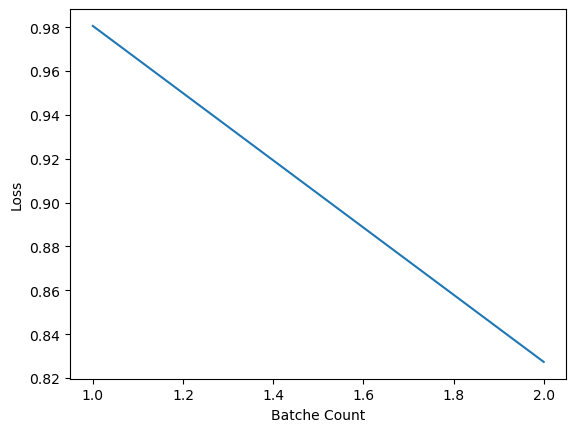

In [349]:
torch.manual_seed(1)
gpt_model = UNetComplex()
loss_function = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(gpt_model.parameters(), lr=0.001) 

training_dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', count=10)

training_loader = DataLoader(training_dataset, batch_size=10, shuffle=True) 

average_loss = train_one_epoch(gpt_model, loss_function, optimizer, training_loader, verbose=True, batch_stop=0,verbose_interval=1, show_graph=True) 

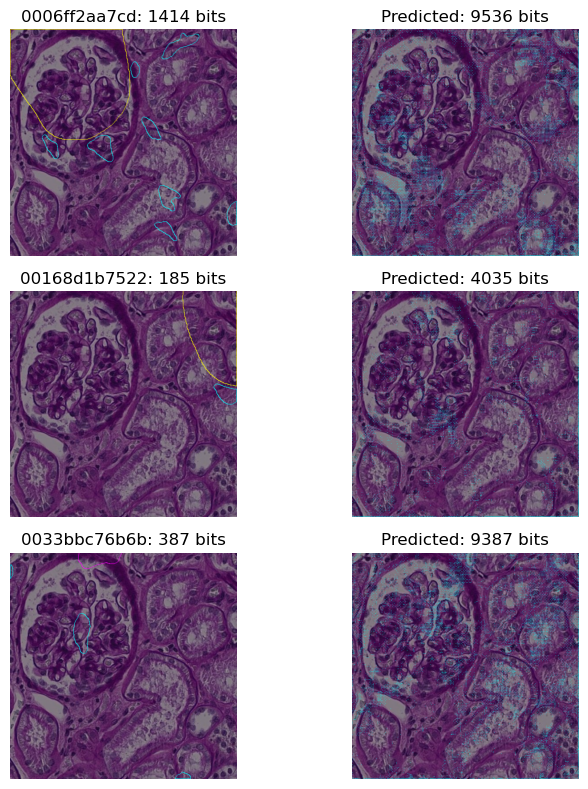

In [350]:
pred_vs_label(gpt_model, result_ids[:3])


In [351]:
calculate_accuracy(gpt_model, dat, break_after=10)


0.002170562744140625